adapted from https://github.com/vboussange/lineax/blob/main/docs/examples/preconditioner.ipynb

In [1]:
import os

#using GPU, comment out if on CPU
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '5'


In [2]:
import jax
import jax.numpy as jnp
import jax.random as jr
from scipy.sparse import diags, kron, eye
import jax.experimental.sparse as js
import lineax as lx


def poisson(n, m):
    """
    Create a 2D Laplacian matrix on an n-by-m grid as a JAX BCOO sparse matrix.
    """
    lap_1d_n = diags([-1, 2, -1], [-1, 0, 1], shape=(n, n), format="csr")
    lap_1d_m = diags([-1, 2, -1], [-1, 0, 1], shape=(m, m), format="csr")
    lap_2d = kron(eye(m, format="csr"), lap_1d_n) + kron(lap_1d_m, eye(n, format="csr"))
    return js.BCOO.from_scipy_sparse(lap_2d)


In [3]:


# Set up the problem: A x = b
n, m = 25, 25
rho_n = 1000

In [4]:
#gaussian blob...

density = jnp.zeros((n,m))
density = density.at[int(n/2),int(m/2)].set(rho_n)

In [5]:

A = poisson(n, m)
key = jr.PRNGKey(0)
b = density.flatten()

in_structure = jax.eval_shape(lambda: b)

In [6]:
import jax
import jax.numpy as jnp
import lineax as lx
from jax.experimental.sparse import BCOO

# Define operator and solve with GMRES



class SparseMatrixLinearOperator(lx.MatrixLinearOperator):
    def mv(self, vector):
        return self.matrix @ vector
    def transpose(self):
        return SparseMatrixLinearOperator(self.matrix.transpose())

@lx.is_positive_semidefinite.register(SparseMatrixLinearOperator)
def _(op):
    return True
    
operator = SparseMatrixLinearOperator(A)
solver = lx.GMRES(atol=1e-5, rtol=1e-5)#, max_steps=100)
x = lx.linear_solve(operator, b, solver=solver, throw=False).value

In [7]:
# Check the residual norm
error = jnp.linalg.norm(b - (A @ x))
error

Array(0.00038905, dtype=float32)

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/home/ben.horowitz/miniconda3/envs/jax-gpu/lib/python3.11/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['eye', 'kron', 'poisson']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


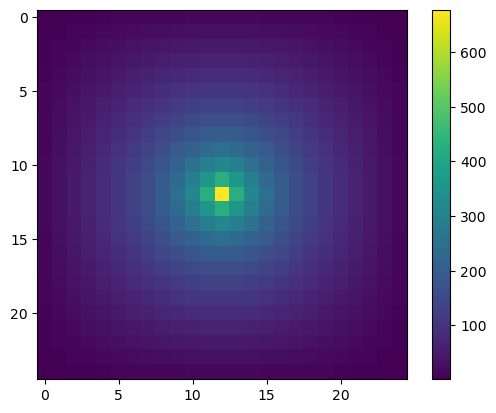

In [8]:
%pylab inline
imshow(x.reshape(m,n))
colorbar()

In [9]:
#lets see if derivates work...

In [10]:
import equinox

@equinox.filter_jit
def likelihood(b):
    x2 = lx.linear_solve(operator, 
                    b, 
                    solver=solver, 
                    throw=False).value
    return jnp.sum(x2**2)

In [27]:
likelihood(b)

Array(7913929.5, dtype=float32)

In [28]:
test_grad = jax.grad(likelihood)

In [29]:
test_grad(b)

ERROR:2025-03-26 21:53:52,002:jax._src.callback:97: jax.pure_callback failed
Traceback (most recent call last):
  File "/home/ben.horowitz/miniconda3/envs/jax-gpu/lib/python3.11/site-packages/jax/_src/callback.py", line 95, in pure_callback_impl
    return tree_util.tree_map(np.asarray, callback(*args))
                                          ^^^^^^^^^^^^^^^
  File "/home/ben.horowitz/miniconda3/envs/jax-gpu/lib/python3.11/site-packages/jax/_src/callback.py", line 72, in __call__
    return tree_util.tree_leaves(self.callback_func(*args, **kwargs))
                                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/ben.horowitz/miniconda3/envs/jax-gpu/lib/python3.11/site-packages/equinox/_errors.py", line 89, in raises
    raise _EquinoxRuntimeError(
equinox._errors._EquinoxRuntimeError: A stagnation in an iterative linear solve has occurred. Try increasing `stagnation_iters` or `restart`.


--------------------
An error occurred during the runtime of your JAX program!

XlaRuntimeError: INTERNAL: CustomCall failed: CpuCallback error: Traceback (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/home/ben.horowitz/miniconda3/envs/jax-gpu/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>
  File "/home/ben.horowitz/miniconda3/envs/jax-gpu/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance
  File "/home/ben.horowitz/miniconda3/envs/jax-gpu/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 739, in start
  File "/home/ben.horowitz/miniconda3/envs/jax-gpu/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 205, in start
  File "/home/ben.horowitz/miniconda3/envs/jax-gpu/lib/python3.11/asyncio/base_events.py", line 608, in run_forever
  File "/home/ben.horowitz/miniconda3/envs/jax-gpu/lib/python3.11/asyncio/base_events.py", line 1936, in _run_once
  File "/home/ben.horowitz/miniconda3/envs/jax-gpu/lib/python3.11/asyncio/events.py", line 84, in _run
  File "/home/ben.horowitz/miniconda3/envs/jax-gpu/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue
  File "/home/ben.horowitz/miniconda3/envs/jax-gpu/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 534, in process_one
  File "/home/ben.horowitz/miniconda3/envs/jax-gpu/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell
  File "/home/ben.horowitz/miniconda3/envs/jax-gpu/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 362, in execute_request
  File "/home/ben.horowitz/miniconda3/envs/jax-gpu/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 778, in execute_request
  File "/home/ben.horowitz/miniconda3/envs/jax-gpu/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 449, in do_execute
  File "/home/ben.horowitz/miniconda3/envs/jax-gpu/lib/python3.11/site-packages/ipykernel/zmqshell.py", line 549, in run_cell
  File "/home/ben.horowitz/miniconda3/envs/jax-gpu/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3006, in run_cell
  File "/home/ben.horowitz/miniconda3/envs/jax-gpu/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3061, in _run_cell
  File "/home/ben.horowitz/miniconda3/envs/jax-gpu/lib/python3.11/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
  File "/home/ben.horowitz/miniconda3/envs/jax-gpu/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3266, in run_cell_async
  File "/home/ben.horowitz/miniconda3/envs/jax-gpu/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3445, in run_ast_nodes
  File "/home/ben.horowitz/miniconda3/envs/jax-gpu/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3505, in run_code
  File "/tmp/ipykernel_40584/3600491937.py", line 1, in <module>
  File "/home/ben.horowitz/miniconda3/envs/jax-gpu/lib/python3.11/site-packages/jax/_src/traceback_util.py", line 180, in reraise_with_filtered_traceback
  File "/home/ben.horowitz/miniconda3/envs/jax-gpu/lib/python3.11/site-packages/jax/_src/api.py", line 394, in grad_f
  File "/home/ben.horowitz/miniconda3/envs/jax-gpu/lib/python3.11/site-packages/jax/_src/traceback_util.py", line 180, in reraise_with_filtered_traceback
  File "/home/ben.horowitz/miniconda3/envs/jax-gpu/lib/python3.11/site-packages/jax/_src/api.py", line 474, in value_and_grad_f
  File "/home/ben.horowitz/miniconda3/envs/jax-gpu/lib/python3.11/site-packages/jax/_src/tree_util.py", line 476, in __call__
  File "/home/ben.horowitz/miniconda3/envs/jax-gpu/lib/python3.11/site-packages/jax/_src/api.py", line 1899, in _vjp_pullback_wrapper
  File "/home/ben.horowitz/miniconda3/envs/jax-gpu/lib/python3.11/site-packages/jax/_src/tree_util.py", line 476, in __call__
  File "/home/ben.horowitz/miniconda3/envs/jax-gpu/lib/python3.11/site-packages/jax/_src/interpreters/ad.py", line 259, in unbound_vjp
  File "/home/ben.horowitz/miniconda3/envs/jax-gpu/lib/python3.11/site-packages/jax/_src/interpreters/ad.py", line 360, in backward_pass
  File "/home/ben.horowitz/miniconda3/envs/jax-gpu/lib/python3.11/site-packages/jax/_src/pjit.py", line 2378, in _pjit_transpose
  File "/home/ben.horowitz/miniconda3/envs/jax-gpu/lib/python3.11/site-packages/jax/_src/core.py", line 463, in bind
  File "/home/ben.horowitz/miniconda3/envs/jax-gpu/lib/python3.11/site-packages/jax/_src/core.py", line 468, in bind_with_trace
  File "/home/ben.horowitz/miniconda3/envs/jax-gpu/lib/python3.11/site-packages/jax/_src/core.py", line 954, in process_primitive
  File "/home/ben.horowitz/miniconda3/envs/jax-gpu/lib/python3.11/site-packages/jax/_src/pjit.py", line 1762, in _pjit_call_impl
  File "/home/ben.horowitz/miniconda3/envs/jax-gpu/lib/python3.11/site-packages/jax/_src/pjit.py", line 1738, in call_impl_cache_miss
  File "/home/ben.horowitz/miniconda3/envs/jax-gpu/lib/python3.11/site-packages/jax/_src/pjit.py", line 1692, in _pjit_call_impl_python
  File "/home/ben.horowitz/miniconda3/envs/jax-gpu/lib/python3.11/site-packages/jax/_src/profiler.py", line 333, in wrapper
  File "/home/ben.horowitz/miniconda3/envs/jax-gpu/lib/python3.11/site-packages/jax/_src/interpreters/pxla.py", line 1289, in __call__
  File "/home/ben.horowitz/miniconda3/envs/jax-gpu/lib/python3.11/site-packages/jax/_src/interpreters/mlir.py", line 2960, in _wrapped_callback
  File "/home/ben.horowitz/miniconda3/envs/jax-gpu/lib/python3.11/site-packages/jax/_src/callback.py", line 306, in _callback
  File "/home/ben.horowitz/miniconda3/envs/jax-gpu/lib/python3.11/site-packages/jax/_src/callback.py", line 98, in pure_callback_impl
  File "/home/ben.horowitz/miniconda3/envs/jax-gpu/lib/python3.11/site-packages/jax/_src/callback.py", line 72, in __call__
  File "/home/ben.horowitz/miniconda3/envs/jax-gpu/lib/python3.11/site-packages/equinox/_errors.py", line 89, in raises
_EquinoxRuntimeError: A stagnation in an iterative linear solve has occurred. Try increasing `stagnation_iters` or `restart`.


--------------------
An error occurred during the runtime of your JAX program! Unfortunately you do not appear to be using `equinox.filter_jit` (perhaps you are using `jax.jit` instead?) and so further information about the error cannot be displayed. (Probably you are seeing a very large but uninformative error message right now.) Please wrap your program with `equinox.filter_jit`.
--------------------


In [11]:
test_grad_fwd = jax.jacfwd(likelihood)

In [12]:
gradfwd = test_grad_fwd(b)

In [13]:
gradfwd #seems to work, but very memory intensive...

Array([  173.54312,   345.60864,   514.3133 ,   677.91144,   834.40216,
         981.5684 ,  1116.9768 ,  1238.0155 ,  1341.9866 ,  1426.2506 ,
        1488.4163 ,  1526.5571 ,  1539.4165 ,  1526.5574 ,  1488.4161 ,
        1426.2512 ,  1341.9868 ,  1238.0161 ,  1116.9773 ,   981.56903,
         834.4021 ,   677.91144,   514.3134 ,   345.6084 ,   173.54329,
         345.60873,   688.06665,  1024.0786 ,  1350.1637 ,  1662.2056 ,
        1955.882  ,  2226.3447 ,  2468.352  ,  2676.4214 ,  2845.2778 ,
        2969.9717 ,  3046.5312 ,  3072.3555 ,  3046.531  ,  2969.972  ,
        2845.2798 ,  2676.422  ,  2468.353  ,  2226.3438 ,  1955.8821 ,
        1662.2039 ,  1350.164  ,  1024.0789 ,   688.0668 ,   345.60834,
         514.31323,  1024.0793 ,  1524.6135 ,  2010.5405 ,  2476.1511 ,
        2914.9543 ,  3319.7156 ,  3682.5522 ,  3995.1372 ,  4249.2554 ,
        4437.225  ,  4552.785  ,  4591.789  ,  4552.785  ,  4437.2256 ,
        4249.256  ,  3995.1357 ,  3682.5532 ,  3319.7183 ,  2914

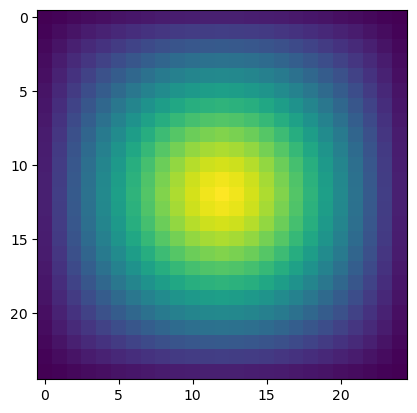

In [14]:
imshow(gradfwd.reshape(m,n))